# XY Model

In [1]:
import numpy as np
import pandas as pd

from pystatplottools.pdf_env.loading_figure_mode import loading_figure_mode
fma, plt = loading_figure_mode(develop=True) # develop=False will export the generated figures as pngs into "./data/RectangleData"
plt.style.use('seaborn-dark-palette')

if 'root_dir' not in locals():
    # Navigate to simulations/XYModel directory as simulation root directory
    import os
    os.chdir("../simulations/XYModel")
    root_dir = os.getcwd()

# To be able to compute custom measures
import sys
sys.path.append("./../../python_scripts")
    
mcmc_model_dir = "XYModelHMC/"
mcmc_data_dir = root_dir + "/data/" + mcmc_model_dir
mcmc_results_dir = root_dir + "/results/" + mcmc_model_dir

data_dir = root_dir + "/data/" + mcmc_model_dir
results_dir = root_dir + "/results/" + mcmc_model_dir

## MCMC Results

### Expectation Values

In [2]:
from mcmctools.modes.expectation_value import load_expectation_value_results
expectation_values = load_expectation_value_results(files_dir="XYModelHMC")
# Insert Beta as column (as floating number)
expectation_values.insert(0, "Beta", expectation_values.index.values.astype(np.float))
expectation_values

Quantity,Beta,ExpVal,Error,ExpVal,Error
Observable,,Energy,Energy,XYMagnetization,XYMagnetization
beta,,,,,
0.050000,0.05,-0.002426,0.000094,0.069700,0.000472
0.200000,0.20,-0.044093,0.000336,0.102275,0.000605
0.350000,0.35,-0.145637,0.000647,0.159609,0.000854
0.500000,0.50,-0.326249,0.001226,0.261780,0.001313
0.650000,0.65,-0.614259,0.001540,0.409347,0.001405
0.800000,0.80,-0.997404,0.001744,0.581084,0.001302
0.950000,0.95,-1.340737,0.001395,0.673116,0.000846
1.100000,1.10,-1.674792,0.001347,0.731929,0.000751


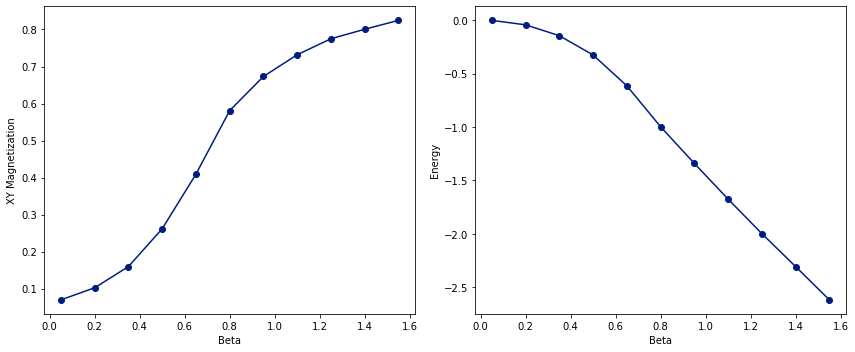

In [3]:
fig, axes = fma.newfig(1.4, ncols=2, figsize=(12, 5))

axes[0].plot(expectation_values["Beta"], expectation_values["ExpVal", "XYMagnetization"], "o-")
axes[0].set_xlabel("Beta")
axes[0].set_ylabel("XY Magnetization")

axes[1].plot(expectation_values["Beta"], expectation_values["ExpVal", "Energy"], "o-")

axes[1].set_xlabel("Beta")
axes[1].set_ylabel("Energy")


plt.tight_layout()

fma.savefig(results_dir, "expectation_values")

## Configurations as Pytorch Dataset

We show how the mcmc configurations can be stored and loaded as a .pt file.

(See also python_scripts/loading_configurations.py and python_scripts/pytorch_data_generation.py)

### Preparation

In [4]:
data_generator_args = {
    # ConfigDataGenerator Args
    "data_type": "target_param",
    # Args for ConfigurationLoader
    "path": mcmc_data_dir,
    "total_number_of_data_per_file": 10000,
    "identifier": "expectation_value",
    "running_parameter": "beta"
    # "chunksize": 100  # If no chunksize is given, all data is loaded at once
}

# Prepare in memory dataset
from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import prepare_in_memory_dataset
from mcmctools.pytorch.data_generation.datagenerationroutines import data_generator_factory

prepare_in_memory_dataset(
    root=data_dir,
    batch_size=89,
    data_generator_args=data_generator_args,
    data_generator_name="BatchConfigDataGenerator",
    data_generator_factory=data_generator_factory
)

Random seed is set by np.random.seed()


### Generating and Loading the Dataset

In [5]:
# Load in memory dataset
from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import load_in_memory_dataset

# The dataset is generated and stored as a .pt file in the data_dir/data directory the first time this function is called. Otherwise the .pt is loaded.
data_loader = load_in_memory_dataset(
    root=data_dir, batch_size=128, data_generator_factory=data_generator_factory, slices=None, shuffle=True,
    num_workers=0, rebuild=False
    # sample_data_generator_name="ConfigDataGenerator"  # optional: for a generation of new samples
)

# Load training data
for batch_idx, batch in enumerate(data_loader):
    data, target = batch
    # print(batch_idx, len(data))

RDKit WARNING: [13:46:17] Enabling RDKit 2019.09.1b1 jupyter extensions


Processing...
Random seed is set by np.random.seed()
Done!


### Inspection of the Dataset - Sample Visualization

In [6]:
from pystatplottools.visualization import sample_visualization

config_dim = (4, 4)  # Dimension of the data
ab=(0, 2 * np.pi)  # Data is expected to be in the range (0, 2 * Pi)

# Random samples
config, label = data_loader.dataset.get_random_sample()
batch, batch_label = data_loader.dataset.get_random_batch(108)

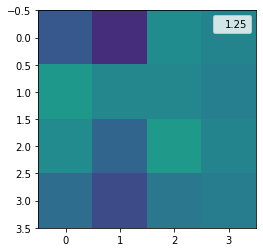

In [7]:
# Single Sample
sample_visualization.fd_im_single_sample(sample=config, label=label, config_dim=config_dim, ab=ab,
                                         fma=fma, filename="single_sample", directory=results_dir, figsize=(10, 4));

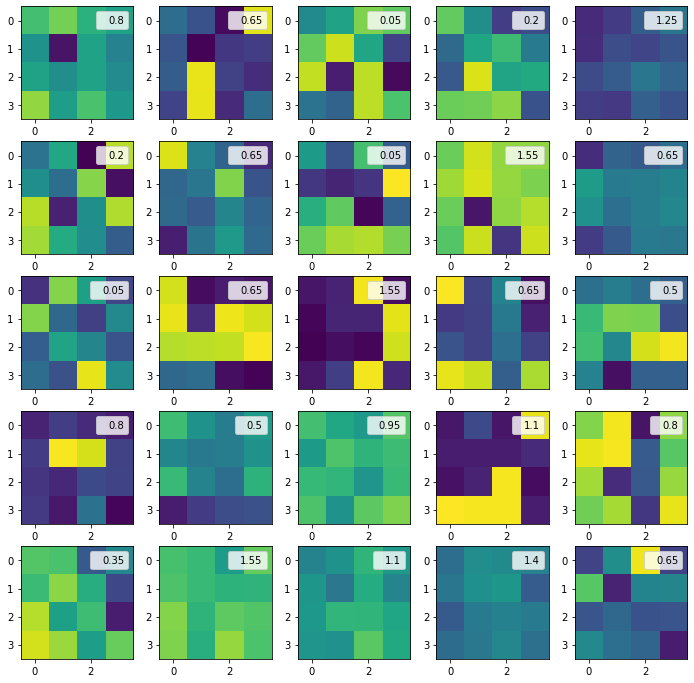

In [8]:
# Batch with labels
sample_visualization.fd_im_batch(batch, batch_labels=batch_label, num_samples=25, dim=(5, 5),
                                 config_dim=config_dim, ab=ab,
                                 fma=fma, filename="batch", directory=results_dir, width=2.3, ratio=1.0, figsize=(12, 12));

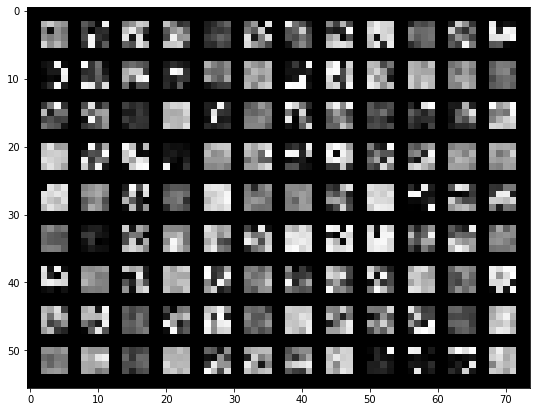

In [9]:
# Batch grid
sample_visualization.fd_im_batch_grid(batch, config_dim=config_dim, ab=ab,
                                      fma=fma, filename="batch_grid", directory=results_dir);